In [0]:
#학습데이터를 구글 드라이버에 저장하고 Colab에서 사용하기 위하여 구글드라이버를 마운트 함
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive')

#사용시에는 "/content/gdrive/My Drive/" 로 패스 설정

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# Colab에서 WebCam 사용하여 이미지 구하기 
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

#WebCam에서 'Capture' 버튼을 클릭하면 당시 화면을 저장  
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg
Emotion Recognition


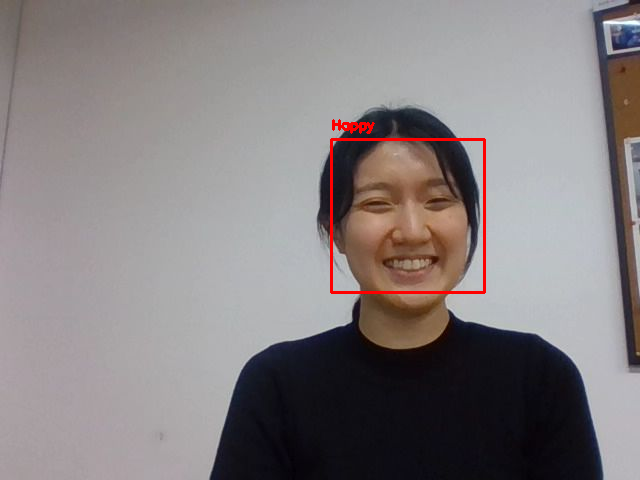

Probabilities


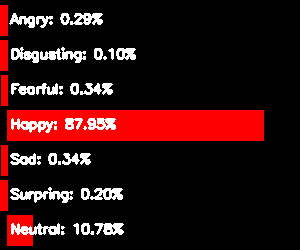

당신은 행복해하는 모습입니다. 신나는 음악을 재생합니다.


In [0]:
import cv2
import numpy as np   
from keras.preprocessing.image import img_to_array
from keras.models import load_model

#Colab에서 사용
from google.colab.patches import cv2_imshow

# 안면인식과 감정분류 학습모델 로딩 
face_detection = cv2.CascadeClassifier('/content/gdrive/My Drive/data/haarcascade_frontalface_default.xml')
emotion_classifier = load_model('/content/gdrive/My Drive/data/emotion_model.hdf5', compile=False)
EMOTIONS = ["Angry" ,"Disgusting","Fearful", "Happy", "Sad", "Surprising", "Neutral"]

# WebCam을 활용하여 안면 이미지를 취득 
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # WebCam에서 저장된 이미지 표시
  #display(Image(filename))
except Exception as err:
  # 오류 발생시에 메시지 표시
  print(str(err))

# cv2 이미지 로딩
frame = cv2.imread(filename, cv2.IMREAD_COLOR)

# 그레이 컬러로 변환
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

# 이미지에서 안면 인식
faces = face_detection.detectMultiScale(gray,
                                        scaleFactor=1.1,
                                        minNeighbors=5,
                                        minSize=(30,30))

# 감정인식 정확도를 표시하기 위한 빈 윈도우 생성
canvas = np.zeros((250, 300, 3), dtype="uint8")

# 안면 인식이 되었을 때에 감정인식 처리 진행 
if len(faces) > 0:
    # 안면을 인식하기 위한 최대 이미지 사이즈 처리
    face = sorted(faces, reverse=True, key=lambda x: (x[2] - x[0]) * (x[3] - x[1]))[0]
    (fX, fY, fW, fH) = face
    # 뉴럴 네트워크를 위하여 이미지 사이즈를 48x48 로 조정 
    roi = gray[fY:fY + fH, fX:fX + fW]
    roi = cv2.resize(roi, (48, 48))
    roi = roi.astype("float") / 255.0
    roi = img_to_array(roi)
    roi = np.expand_dims(roi, axis=0)
    
    # 감정인식 
    preds = emotion_classifier.predict(roi)[0]
    emotion_probability = np.max(preds)
    label = EMOTIONS[preds.argmax()]
    
    # 인식된 감정분류를 라벨링
    cv2.putText(frame, label, (fX, fY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
    cv2.rectangle(frame, (fX, fY), (fX + fW, fY + fH), (0, 0, 255), 2)

    # 감정라벨에 정확도 표시
    for (i, (emotion, prob)) in enumerate(zip(EMOTIONS, preds)):
        text = "{}: {:.2f}%".format(emotion, prob * 100)    
        w = int(prob * 300)
        cv2.rectangle(canvas, (7, (i * 35) + 5), (w, (i * 35) + 35), (0, 0, 255), -1)
        cv2.putText(canvas, text, (10, (i * 35) + 23), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (255, 255, 255), 2)

# Colab에서 감정인식된 안면 이미지와 감정인식 정확도를 화면에 표시
print('Emotion Recognition')
cv2_imshow(frame)

print("Probabilities")
cv2_imshow(canvas)

#감정에 따라 음악재생
if  label == "Angry":
     print("당신은 화가난 모습입니다. 진정시키는 음악을 재생합니다.")
     link = "/content/gdrive/My Drive/data/music/surpring.mp3"
elif label == "Disgusting":
     print("당신은 싫증난 모습입니다. 신나는 음악을 재생합니다.")
     link = "/content/gdrive/My Drive/data/music/Disgusting.mp3"
elif label == "Fearful":
     print("당신은 무서워하는 모습입니다. 평온한 음악을 재생합니다.") 
     link = "/content/gdrive/My Drive/data/music/Fearful.mp3"
elif label == "Happy":
     print("당신은 행복해하는 모습입니다. 신나는 음악을 재생합니다.") 
     link = "/content/gdrive/My Drive/data/music/happy.mp3"
elif label == "Sad":
     print("당신은 슬퍼보이는 모습입니다. 즐거운 음악을 재생합니다.")
     link = "/content/gdrive/My Drive/data/music/sad.mp3"
elif label == "Surprising":
     print("당신은 놀란 모습입니다. 평온한 음악을 재생합니다.")
     link = "/content/gdrive/My Drive/data/music/surpring.mp3"
elif label == "Neutral":
     print("당신은 무표정한 모습입니다. 신나는 음악을 재생합니다.")
     link = "/content/gdrive/My Drive/data/music/neutral.mp3"

#감정에 대응하는 오디오 재생
from IPython.display import Audio
Audio(filename=link,autoplay=True)


In [0]:

# cv2 닫기
cv2.destroyAllWindows()
